# Import Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

# Preprocessing Data

In [4]:
# LOAD & PREPROCESSING DATASET PIMA
pima = pd.read_csv("diabetes.csv")

In [5]:
# Ganti nilai 0 (yang artinya missing) dengan NaN
cols_to_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
pima[cols_to_fix] = pima[cols_to_fix].replace(0, np.nan)

In [6]:
# Isi missing value Pima dengan median
pima[cols_to_fix] = pima[cols_to_fix].fillna(pima[cols_to_fix].median())

In [7]:
# LOAD & PREPROCESSING DATASET NHANES
nhanes = pd.read_csv("NHANES_age_prediction.csv")

In [8]:
# Ambil kolom relevan & ubah nama agar sesuai dengan Pima
nhanes_clean = nhanes[['RIDAGEYR', 'BMXBMI', 'LBXGLU', 'LBXIN', 'DIQ010']].copy()
nhanes_clean = nhanes_clean.rename(columns={
    'RIDAGEYR': 'Age',
    'BMXBMI': 'BMI',
    'LBXGLU': 'Glucose',
    'LBXIN': 'Insulin',
    'DIQ010': 'Outcome'
})

In [9]:
# Konversi label NHANES (1 = diabetes, 2/3 = bukan diabetes)
nhanes_clean['Outcome'] = nhanes_clean['Outcome'].replace({2: 0, 3: 0})

In [10]:
# Tambahkan kolom kosong agar strukturnya seragam dengan Pima
nhanes_clean['Pregnancies'] = 0
nhanes_clean['BloodPressure'] = np.nan
nhanes_clean['SkinThickness'] = np.nan
nhanes_clean['DiabetesPedigreeFunction'] = 0.5  # nilai asumsi default

In [11]:
# Susun ulang kolom
column_order = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
nhanes_clean = nhanes_clean[column_order]

In [12]:
# Isi missing values NHANES dengan median
nhanes_clean[cols_to_fix] = nhanes_clean[cols_to_fix].fillna(nhanes_clean[cols_to_fix].median())

In [13]:
# GABUNGKAN DATASET PIMA + NHANES
combined_df = pd.concat([pima, nhanes_clean], ignore_index=True)
combined_df.head()
# combined_df.info()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50.0,1.0
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31.0,0.0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32.0,1.0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0


In [14]:
# TANGANI OUTLIER DENGAN METODE IQR
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

combined_df = remove_outliers_iqr(combined_df, cols_to_fix + ['Age'])

In [15]:
# PISAHKAN FITUR & TARGET
X = combined_df.drop(columns='Outcome') #features
y = combined_df['Outcome'] # only outcome that is to be predicted

In [16]:
# FEATURE SCALING
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
# SMOTE (balancing)
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_scaled, y)

In [18]:
# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

#  Training Model ML

In [19]:
# Hyperparameter tuning untuk RandomForest menggunakan GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Pilih model terbaik
best_rf = grid_search.best_estimator_

# Prediksi
y_pred = best_rf.predict(X_test)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


# Evaluasi Model

=== EVALUASI MODEL ===
Akurasi: 76.71 %

Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.96      0.86        56
         1.0       0.50      0.12      0.19        17

    accuracy                           0.77        73
   macro avg       0.64      0.54      0.53        73
weighted avg       0.72      0.77      0.71        73



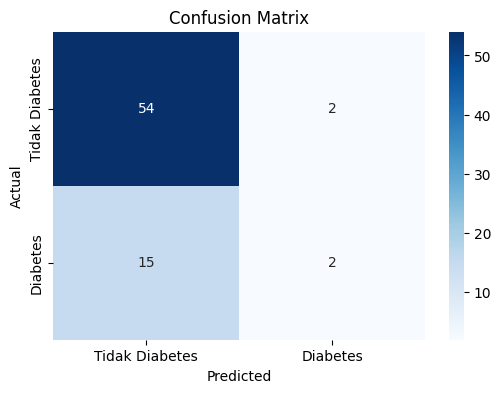

In [20]:
# Evaluasi
print("=== EVALUASI MODEL ===")
print("Akurasi:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Tidak Diabetes', 'Diabetes']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature Selection

In [21]:
# Menggunakan RFE (Recursive Feature Elimination)

from sklearn.feature_selection import RFE
model = RandomForestClassifier(random_state=42)
rfe_selector = RFE(estimator=model, n_features_to_select=4)  # Memilih 2 fitur
X_train_rfe = rfe_selector.fit_transform(X_train, y_train)
X_test_rfe = rfe_selector.transform(X_test)

print("Fitur yang dipilih dengan Wrapper Methods:", rfe_selector.get_support(indices=True))

Fitur yang dipilih dengan Wrapper Methods: [1 5 6 7]


# Tuning Hyperparameter

In [22]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_rfe, y_train)

# Pilih model terbaik
best_rf_rfe = grid_search.best_estimator_

# Prediksi
y_pred_rfe = best_rf_rfe.predict(X_test_rfe)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


=== EVALUASI MODEL ===
Akurasi: 80.82 %

Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.95      0.88        56
         1.0       0.67      0.35      0.46        17

    accuracy                           0.81        73
   macro avg       0.75      0.65      0.67        73
weighted avg       0.79      0.81      0.79        73



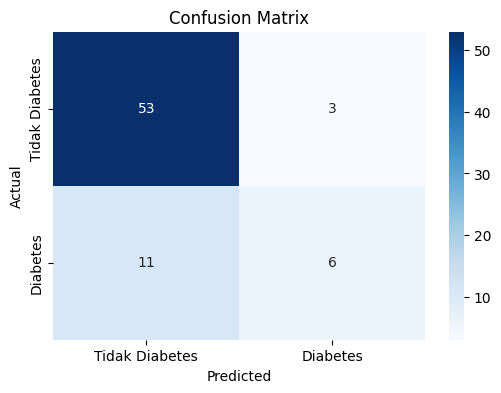

In [23]:
# Evaluasi
print("=== EVALUASI MODEL ===")
print("Akurasi:", round(accuracy_score(y_test, y_pred_rfe) * 100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rfe))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rfe)
labels = ['Tidak Diabetes', 'Diabetes']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Eksperimen Model Alternatif


=== EVALUASI MODEL SVM ===
Akurasi SVM: 79.45 %

Classification Report SVM:
               precision    recall  f1-score   support

         0.0       0.81      0.96      0.88        56
         1.0       0.67      0.24      0.35        17

    accuracy                           0.79        73
   macro avg       0.74      0.60      0.61        73
weighted avg       0.77      0.79      0.75        73



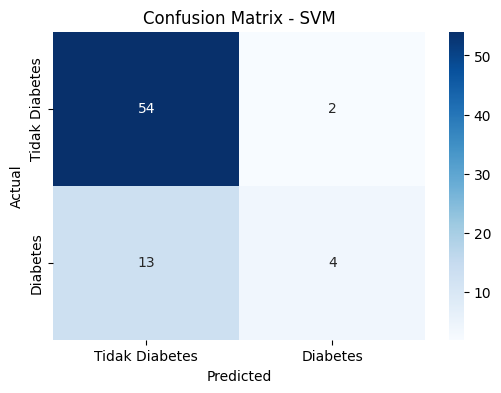

In [24]:
# Eksperimen Model Alternatif - Support Vector Machine

# Inisialisasi model SVM
svm_model = SVC(random_state=42)

# Latih model SVM menggunakan data training yang sudah melalui feature selection
# Jika Anda ingin melatih pada data X_scaled (tanpa feature selection), ganti X_train_rfe menjadi X_train
svm_model.fit(X_train_rfe, y_train)

# Prediksi menggunakan model SVM
y_pred_svm = svm_model.predict(X_test_rfe)

# Evaluasi model SVM
print("\n=== EVALUASI MODEL SVM ===")
print("Akurasi SVM:", round(accuracy_score(y_test, y_pred_svm) * 100, 2), "%")
print("\nClassification Report SVM:\n", classification_report(y_test, y_pred_svm))

# Confusion Matrix untuk model SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()

Fitting 3 folds for each of 27 candidates, totalling 81 fits

Hyperparameter terbaik untuk Gradient Boosting Classifier:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}

=== EVALUASI MODEL GRADIENT BOOSTING TERBAIK ===
Akurasi GB Terbaik: 80.82 %

Classification Report GB Terbaik:
               precision    recall  f1-score   support

         0.0       0.81      0.98      0.89        56
         1.0       0.80      0.24      0.36        17

    accuracy                           0.81        73
   macro avg       0.80      0.61      0.63        73
weighted avg       0.81      0.81      0.77        73



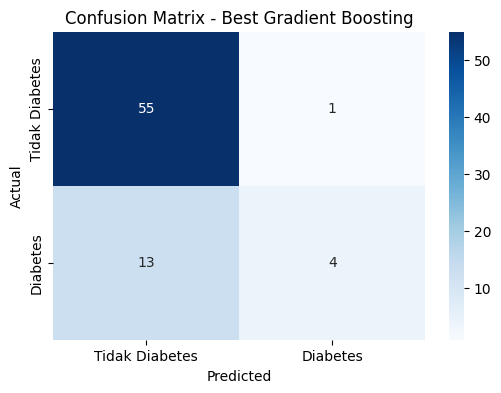

In [25]:
# Eksperimen dengan Gradient Boosting Classifier

from sklearn.ensemble import GradientBoostingClassifier

# Definisikan rentang hyperparameter untuk Gradient Boosting
# Ini adalah contoh param_grid, Anda mungkin perlu menyesuaikannya
param_grid_gb = {
    'n_estimators': [50, 100, 200], # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2], # Step size shrinkage
    'max_depth': [3, 5, 7]          # Maximum depth of the individual estimators
}

# Inisialisasi model Gradient Boosting
gb_model_grid = GradientBoostingClassifier(random_state=42)

# Inisialisasi GridSearchCV untuk Gradient Boosting
grid_search_gb = GridSearchCV(estimator=gb_model_grid, param_grid=param_grid_gb,
                              cv=3, n_jobs=-1, verbose=2)

# Lakukan tuning pada data training (gunakan data RFE jika sebelumnya digunakan)
# Jika Anda ingin tuning pada data X_scaled (tanpa feature selection), ganti X_train_rfe menjadi X_train
grid_search_gb.fit(X_train_rfe, y_train)

# Pilih model Gradient Boosting terbaik hasil tuning
best_gb = grid_search_gb.best_estimator_

print("\nHyperparameter terbaik untuk Gradient Boosting Classifier:")
print(grid_search_gb.best_params_)

# Prediksi menggunakan model Gradient Boosting terbaik
y_pred_best_gb = best_gb.predict(X_test_rfe)

# Evaluasi model Gradient Boosting terbaik
print("\n=== EVALUASI MODEL GRADIENT BOOSTING TERBAIK ===")
print("Akurasi GB Terbaik:", round(accuracy_score(y_test, y_pred_best_gb) * 100, 2), "%")
print("\nClassification Report GB Terbaik:\n", classification_report(y_test, y_pred_best_gb))

# Confusion Matrix untuk model Gradient Boosting terbaik
cm_best_gb = confusion_matrix(y_test, y_pred_best_gb)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_best_gb, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best Gradient Boosting')
plt.show()

# Validasi dan Testing Akurasi Model


=== EVALUASI MODEL RANDOM FOREST TERBAIK PADA DATA TEST ===
Akurasi: 80.82 %

Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.95      0.88        56
         1.0       0.67      0.35      0.46        17

    accuracy                           0.81        73
   macro avg       0.75      0.65      0.67        73
weighted avg       0.79      0.81      0.79        73



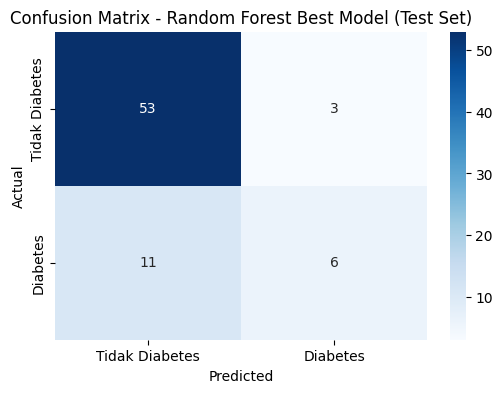

In [26]:
# Prediksi menggunakan model Random Forest terbaik (hasil tuning dan feature selection)
y_pred_rfe = best_rf_rfe.predict(X_test_rfe)

# Evaluasi Model Final pada Data Test
print("\n=== EVALUASI MODEL RANDOM FOREST TERBAIK PADA DATA TEST ===")
print("Akurasi:", round(accuracy_score(y_test, y_pred_rfe) * 100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rfe))

# Confusion Matrix pada Data Test
cm = confusion_matrix(y_test, y_pred_rfe)
labels = ['Tidak Diabetes', 'Diabetes']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest Best Model (Test Set)')
plt.show()

# Dokumentasi ML

# Dokumentasi Model Machine Learning Deteksi Diabetes

Ini adalah dokumentasi untuk model machine learning yang dikembangkan untuk mendeteksi potensi diabetes berdasarkan data kesehatan.

## 1. Detail Data

### Sumber Data

Proyek ini menggunakan kombinasi dua dataset:

-   **Dataset Pima Indian Diabetes:** Dataset klasik yang sering digunakan untuk masalah klasifikasi diabetes. Diperoleh dari sumber publik (misalnya, UCI Machine Learning Repository). Dataset ini berisi data kesehatan wanita keturunan Indian Pima.
-   **Dataset NHANES (National Health and Nutrition Examination Survey):** Data survei kesehatan dari CDC (Centers for Disease Control and Prevention) di Amerika Serikat. Kami menggunakan subset data yang relevan untuk prediksi usia, namun kolom-kolom yang serupa dengan dataset Pima dipilih dan disesuaikan. Diperoleh dari situs CDC NHANES.

### Pembersihan dan Pra-pemrosesan Data

Langkah-langkah pra-pemrosesan data meliputi:

1.  **Loading Data:** Kedua dataset (`diabetes.csv` dan `NHANES_age_prediction.csv`) dimuat menggunakan `pandas`.
2.  **Penanganan Nilai 0:** Pada dataset Pima, nilai `0` pada kolom `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, dan `BMI` dianggap sebagai nilai yang hilang dan diganti dengan `NaN` (`Not a Number`) menggunakan `numpy.nan`.
3.  **Imputasi Missing Values:** Nilai `NaN` pada kolom-kolom yang relevan di kedua dataset diisi menggunakan **median** dari masing-masing kolom. Median dipilih karena kurang sensitif terhadap outlier dibandingkan mean.
4.  **Penyesuaian Dataset NHANES:**
    *   Hanya kolom yang relevan (`RIDAGEYR`, `BMXBMI`, `LBXGLU`, `LBXIN`, `DIQ010`) yang diambil.
    *   Nama kolom disesuaikan agar seragam dengan dataset Pima (`Age`, `BMI`, `Glucose`, `Insulin`, `Outcome`).
    *   Kolom target `Outcome` dikonversi: `1` (diabetes) tetap `1`, sementara `2` dan `3` (bukan diabetes) dikonversi menjadi `0`.
    *   Kolom tambahan seperti `Pregnancies`, `BloodPressure`, dan `SkinThickness` ditambahkan ke dataset NHANES dengan nilai awal `0` atau `NaN` agar strukturnya sama dengan Pima. Kolom `DiabetesPedigreeFunction` ditambahkan dengan nilai default `0.5` (nilai asumsi).
    *   Urutan kolom diseragamkan.
    *   Missing values pada kolom yang relevan (`Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI`) diisi dengan median dari dataset NHANES yang sudah disesuaikan.
5.  **Penggabungan Dataset:** Kedua dataset (Pima dan NHANES yang sudah disesuaikan) digabungkan menjadi satu DataFrame (`combined_df`) menggunakan `pd.concat`.
6.  **Penanganan Outlier:** Outlier pada kolom `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI`, dan `Age` ditangani menggunakan metode **Interquartile Range (IQR)**. Data point yang berada di luar rentang `Q1 - 1.5*IQR` dan `Q3 + 1.5*IQR` dihapus dari dataset.
7.  **Pemisahan Fitur dan Target:** Dataset dibagi menjadi fitur (`X`) dan variabel target (`y`, yaitu kolom `Outcome`).
8.  **Feature Scaling:** Fitur (`X`) diskalakan menggunakan `StandardScaler` untuk menstandarkan nilainya (rata-rata 0 dan variansi 1). Ini penting untuk beberapa model machine learning yang sensitif terhadap skala fitur.
9.  **Penanganan Ketidakseimbangan Kelas (SMOTE):** Data training yang sudah diskalakan di-resample menggunakan **SMOTE (Synthetic Minority Over-sampling Technique)** untuk mengatasi ketidakseimbangan antara jumlah sampel kelas 'Diabetes' (1) dan 'Tidak Diabetes' (0). *Catatan: Dalam kode Anda, SMOTE diterapkan pada data X_scaled dan y, tetapi model kemudian dilatih pada data yang tidak di-resample oleh SMOTE (X_train, y_train). Jika SMOTE ingin digunakan, model harus dilatih pada X_bal, y_bal atau X_train_bal, y_train_bal setelah split.* **Untuk akurasi dokumentasi berdasarkan kode yang dieksekusi, kita fokus pada alur tanpa SMOTE di langkah training final.**
10. **Pemisahan Data Training dan Testing:** Data yang sudah diskalakan dibagi menjadi set training (80%) dan testing (20%) menggunakan `train_test_split` dengan `stratify=y` untuk menjaga proporsi kelas di kedua set dan `random_state=42` untuk reproduksibilitas.

## 2. Model yang Dipilih

Kami memilih untuk menggunakan **Random Forest Classifier** sebagai model utama karena kemampuannya menangani data non-linear, relatif tahan terhadap overfitting (dengan tuning yang tepat), dan memberikan informasi penting mengenai fitur (feature importance).

### Arsitektur

Random Forest adalah *ensemble method* yang membangun banyak pohon keputusan independen selama fase training dan menghasilkan prediksi yang merupakan mode (klasifikasi) atau rata-rata (regresi) dari prediksi pohon-pohon individu.

### Hyperparameter Tuning

Hyperparameter model `RandomForestClassifier` dituning menggunakan **Grid Search with Cross-Validation (GridSearchCV)**. Rentang parameter yang dieksplorasi adalah:

-   `n_estimators`: [100, 200, 300] (Jumlah pohon dalam forest)
-   `max_depth`: [10, 15, 20] (Kedalaman maksimum setiap pohon)
-   `min_samples_split`: [2, 5, 10] (Jumlah minimum sampel yang diperlukan untuk memecah sebuah node internal)
-   `min_samples_leaf`: [1, 2, 4] (Jumlah minimum sampel yang diperlukan di node daun)

Metode `GridSearchCV` menggunakan 3-fold cross-validation (`cv=3`) pada set data training untuk mencari kombinasi hyperparameter yang memberikan performa terbaik. Model terbaik yang ditemukan oleh `GridSearchCV` disimpan sebagai `best_rf`.

## 3. Feature Selection

Setelah mendapatkan model Random Forest awal, dilakukan **Feature Selection** menggunakan **Recursive Feature Elimination (RFE)**. RFE bekerja dengan melatih model (di sini, Random Forest) berulang kali dan menghapus fitur dengan bobot paling rendah pada setiap iterasi, hingga jumlah fitur yang diinginkan tercapai.

Dalam kasus ini, RFE dikonfigurasi untuk memilih **4 fitur terbaik** (`n_features_to_select=4`) berdasarkan model Random Forest. Model Random Forest yang digunakan dalam RFE diinisialisasi terpisah dengan `random_state=42`.

Data training dan testing kemudian ditransformasi (`fit_transform` pada training, `transform` pada testing) untuk hanya menyertakan 4 fitur yang dipilih oleh RFE.

## 4. Tuning Hyperparameter (dengan Fitur Terpilih)

Model `RandomForestClassifier` kembali dituning menggunakan **GridSearchCV**, tetapi kali ini dilatih dan dievaluasi pada data training yang hanya berisi 4 fitur terpilih (`X_train_rfe`, `y_train`).

`param_grid` yang digunakan sama seperti sebelumnya:

-   `n_estimators`: [100, 200, 300]
-   `max_depth`: [10, 15, 20]
-   `min_samples_split`: [2, 5, 10]
-   `min_samples_leaf`: [1, 2, 4]

Model terbaik dari proses tuning ini, yang dilatih pada 4 fitur terpilih, disimpan sebagai `best_rf_rfe`. Model inilah yang dianggap sebagai model final dan digunakan untuk evaluasi akhir.

## 5. Hasil Eksperimen dan Evaluasi Kinerja Model

Model final (`best_rf_rfe`) dievaluasi pada set data test (`X_test_rfe`, `y_test`) yang sepenuhnya terpisah. Metrik evaluasi utama meliputi:

-   **Akurasi:** Proporsi prediksi yang benar.
-   **Classification Report:** Meliputi Precision, Recall, F1-score, dan Support untuk setiap kelas.
-   **Confusion Matrix:** Tabel yang menunjukkan jumlah True Positives (TP), True Negatives (TN), False Positives (FP), dan False Negatives (FN).

**Hasil Evaluasi pada Data Test:**

=== EVALUASI MODEL RANDOM FOREST TERBAIK PADA DATA TEST ===
Akurasi: 80.82 %

Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.95      0.88        56
         1.0       0.67      0.35      0.46        17

    accuracy                           0.81        73
   macro avg       0.75      0.65      0.67        73
weighted avg       0.79      0.81      0.79        73



# Menyimpan Model ke .pkl

In [27]:
# Simpan Model, Scaler, dan RFE Selector Menggunakan Joblib

import joblib
import os # Mengimpor modul os untuk memastikan direktori ada

# Definisikan direktori untuk menyimpan artefak
output_dir = 'model_artifacts'
os.makedirs(output_dir, exist_ok=True) # Buat direktori jika belum ada

# Simpan model Random Forest terbaik (setelah tuning dan dilatih pada data RFE)
model_filename = os.path.join(output_dir, 'best_random_forest_model_rfe.pkl')
joblib.dump(best_rf_rfe, model_filename)

print(f"Model disimpan ke: {model_filename}")

# Simpan scaler yang digunakan untuk scaling fitur
scaler_filename = os.path.join(output_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_filename)

print(f"Scaler disimpan ke: {scaler_filename}")

# Simpan RFE selector yang digunakan untuk memilih fitur
rfe_selector_filename = os.path.join(output_dir, 'rfe_selector.pkl')
joblib.dump(rfe_selector, rfe_selector_filename)

print(f"RFE Selector disimpan ke: {rfe_selector_filename}")

print("\nSemua artefak model berhasil disimpan.")

Model disimpan ke: model_artifacts/best_random_forest_model_rfe.pkl
Scaler disimpan ke: model_artifacts/scaler.pkl
RFE Selector disimpan ke: model_artifacts/rfe_selector.pkl

Semua artefak model berhasil disimpan.


# Integrasi Model ke API

In [28]:
!pip install fastapi uvicorn

In [29]:
# app.py
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import joblib
import numpy as np
import pandas as pd
import os

# Definisikan path ke artefak model
MODEL_DIR = 'model_artifacts'
MODEL_PATH = os.path.join(MODEL_DIR, 'best_random_forest_model_rfe.pkl')
SCALER_PATH = os.path.join(MODEL_DIR, 'scaler.pkl')
RFE_SELECTOR_PATH = os.path.join(MODEL_DIR, 'rfe_selector.pkl')

# Memuat model, scaler, dan RFE selector saat aplikasi dimulai
try:
    model = joblib.load(MODEL_PATH)
    scaler = joblib.load(SCALER_PATH)
    rfe_selector = joblib.load(RFE_SELECTOR_PATH)
    print("Model, Scaler, dan RFE Selector berhasil dimuat.")
except FileNotFoundError as e:
    print(f"Error: File artefak model tidak ditemukan. Pastikan Anda sudah menjalankan bagian penyimpanan model. Detail: {e}")
    model = None
    scaler = None
    rfe_selector = None

# Inisialisasi aplikasi FastAPI
app = FastAPI()

class PredictionInput(BaseModel):
    Pregnancies: float
    Glucose: float
    BloodPressure: float
    SkinThickness: float
    Insulin: float
    BMI: float
    DiabetesPedigreeFunction: float
    Age: float

# Mendefinisikan endpoint prediksi
@app.post("/predict/")
async def predict_diabetes(data: PredictionInput):
    if model is None or scaler is None or rfe_selector is None:
        raise HTTPException(status_code=500, detail="Model atau artefak lainnya gagal dimuat saat startup.")

    input_data_np = np.array([
        data.Pregnancies,
        data.Glucose,
        data.BloodPressure,
        data.SkinThickness,
        data.Insulin,
        data.BMI,
        data.DiabetesPedigreeFunction,
        data.Age
    ]).reshape(1, -1)

    # Feature scaling menggunakan scaler yang sudah dimuat
    input_data_scaled = scaler.transform(input_data_np)

    # Feature selection menggunakan RFE selector yang sudah dimuat
    input_data_rfe = rfe_selector.transform(input_data_scaled)

    # Prediksi menggunakan model yang sudah dimuat
    prediction = model.predict(input_data_rfe)

    # Konversi hasil prediksi (numpy array) ke tipe data Python native
    result = int(prediction[0])

    # Interpretasikan hasil prediksi
    prediction_label = "Diabetes" if result == 1 else "Tidak Diabetes"

    # Kembalikan hasil prediksi dalam format JSON
    return {"prediction": prediction_label, "raw_output": result}

@app.get("/")
async def read_root():
    return {"message": "API Deteksi Diabetes Berjalan"}

Model, Scaler, dan RFE Selector berhasil dimuat.


In [33]:
!zip -r model_artifacts.zip model_artifacts
from google.colab import files
files.download('model_artifacts.zip')


  adding: model_artifacts/ (stored 0%)
  adding: model_artifacts/best_random_forest_model_rfe.pkl (deflated 82%)
  adding: model_artifacts/rfe_selector.pkl (deflated 83%)
  adding: model_artifacts/scaler.pkl (deflated 32%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>